In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [74]:
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller as ADF

In [2]:
#数据读取
order_data=pd.read_excel('./order_data.xlsx',sheet_name='订单表')
city_data=pd.read_excel('./order_data.xlsx',sheet_name='城市表')
cus_data=pd.read_excel('./order_data.xlsx',sheet_name='客户表')
saler_data=pd.read_excel('./order_data.xlsx',sheet_name='销售人员表')

# 目前经营情况分析
## 角度：
    - 订单量
    - 销售金额
    - 销售利润
    - 利润率
    

### 订单量

In [3]:
#去除异常订单日期数据
order_data=order_data[order_data['订单日期'].apply(type)!=int]

In [18]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   产品ID    25000 non-null  object 
 1   订单ID    25000 non-null  int64  
 2   客户ID    25000 non-null  int64  
 3   订单日期    25000 non-null  object 
 4   发货日期    25000 non-null  object 
 5   销售经理ID  25000 non-null  object 
 6   利润      25000 non-null  float64
 7   折扣      25000 non-null  float64
 8   数量      25000 non-null  int64  
 9   是否退回    25000 non-null  int64  
 10  计划发货天数  25000 non-null  int64  
 11  销售额     25000 non-null  float64
 12  实际发货天数  25000 non-null  int64  
 13  产品类型    25000 non-null  object 
 14  产品名称    25000 non-null  object 
 15  产品单价    25000 non-null  float64
 16  产品成本价   25000 non-null  int64  
dtypes: float64(4), int64(7), object(6)
memory usage: 4.1+ MB


In [4]:
#产品类型维度
order_data['month']=order_data['订单日期'].apply(str).str[:7]
order_data['quater']=pd.PeriodIndex(order_data['订单日期'].astype('datetime64'), freq='Q').astype('str')
order_data['year']=pd.to_datetime(order_data['订单日期']).dt.year


In [5]:
order_data['1-12month']=pd.to_datetime(order_data['订单日期']).dt.month
#是为了看有无季节周期性

In [106]:
order_year=order_data.groupby('year').agg({
    '订单ID':'count',
    '销售额':'sum',
    '利润':'sum',
    '数量':'sum'
}).rename(columns={
    '订单ID':'订单数量',
    '数量':'销量'
})

In [131]:
order_year['利润率']=order_year['利润']/order_year['销售额']

In [132]:
profit_rate_label=['%.2f%%' % (i*100) for i in  order_year['利润率']]

In [133]:
profit_rate_label

['53.98%', '54.25%', '53.99%']

In [130]:
order_year['销售额增长率']=(order_year['销售额'].diff()/order_year['销售额']).fillna(0)

In [128]:
sale_rate_label=['%.2f%%'%(i*100) for i in order_year['销售额增长率']]

In [129]:
sale_rate_label

['0.00%', '0.83%', '-2.25%']

In [135]:
y1=order_year['销售额']
y2=order_year['销售额增长率']
x=[str(i) for i in order_year.index]

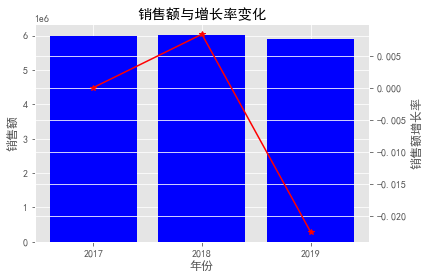

In [138]:
#设置风格
plt.style.use('ggplot')
y1=order_year['销售额']
y2=order_year['销售额增长率']
x=[str(i) for i in order_year.index]
#新建figure对象
fig=plt.figure()
#新建子图
ax1=fig.add_subplot(1,1,1)
#ax2与ax1共享x轴
ax2=ax1.twinx()
ax1.bar(x,y1,color='blue')
ax2.plot(x,y2,marker='*',color='r')
ax1.set_xlabel('年份')
ax1.set_ylabel('销售额')
ax2.set_ylabel('销售额增长率')
ax1.set_title('销售额与增长率变化')
plt.show()

In [137]:
y2


year
2017    0.000000
2018    0.008319
2019   -0.022484
Name: 销售额增长率, dtype: float64

In [89]:
order_quater=order_data.groupby('quater').agg({
    '订单ID':'count',
    '销售额':'sum',
    '利润':'sum',
    '数量':'sum'
}).rename(columns={
    '订单ID':'订单数量',
    '数量':'销量'
})

In [96]:
order_quater['利润率']=['%.2f%%' % (i*100) for i in  order_quater['利润']/order_quater['销售额']]
# ["%.2f%%"%(i/sum(df.values)*100) for i in df.values]

In [97]:
order_quater

,订单数量,销售额,利润,销量,利润率
quater,,,,,
2017Q1,2038,1467185.0,790634.700,11050,53.89%
2017Q2,2103,1417899.5,768580.645,11545,54.21%
2017Q3,2138,1506792.0,813116.545,11880,53.96%
2017Q4,2156,1581162.7,852088.905,11963,53.89%
2018Q1,2111,1460510.5,794525.040,11585,54.40%
2018Q2,2056,1502694.9,811823.595,11401,54.02%
2018Q3,2073,1522755.0,826808.375,11620,54.30%
2018Q4,2117,1537186.5,834431.840,11685,54.28%
2019Q1,2037,1405149.6,753042.725,11244,53.59%


<BarContainer object of 12 artists>

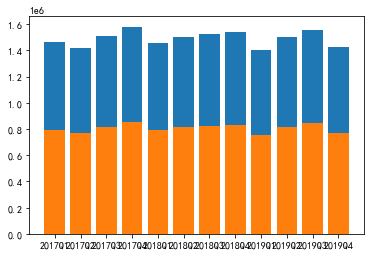

In [105]:
# plt.plot(order_quater['销售额'])
plt.bar(x=order_quater.index,height=order_quater['销售额'])
plt.bar(x=order_quater.index,height=order_quater['利润'])
# plt.plot(order_quater['利润率'])

In [86]:
order_data[['quater','客户ID']].drop_duplicates().groupby('quater')['客户ID'].count()

quater
2017Q1    729
2017Q2    727
2017Q3    735
2017Q4    727
2018Q1    732
2018Q2    734
2018Q3    739
2018Q4    747
2019Q1    727
2019Q2    741
2019Q3    726
2019Q4    735
Name: 客户ID, dtype: int64

In [ ]:
order_data.groupby('quater').agg({
    ''
})

In [35]:
product_quater=pd.pivot_table(order_data,columns='产品类型',index='quater',values='订单ID',aggfunc='count')

In [54]:
product_quater

产品类型,冬装,夏装,秋装
quater,,,
2017Q1,1083,477,478
2017Q2,1125,476,502
2017Q3,1054,530,554
2017Q4,1152,502,502
2018Q1,1141,505,465
2018Q2,1095,470,491
2018Q3,1069,519,485
2018Q4,1149,494,474
2019Q1,1063,492,482


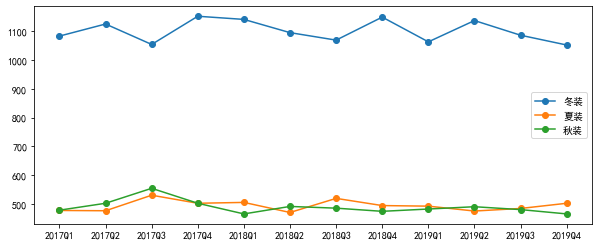

In [63]:
# f,ax=plt.subplots(3,1)
f,ax=plt.subplots(figsize=(10,4))
for col in product_quater.columns:
    plt.plot(product_quater[col],marker='o',linestyle='-')
plt.legend(labels=['冬装','夏装','秋装'])
plt.show()

- 可以看出冬装和夏装周期性明显，并可以预测2020第1季度，冬装订单量会下降，夏装订单量会上升，夏装订单量以1年为1周期

In [68]:
product_month=pd.pivot_table(order_data,columns='产品类型',index='month',values='订单ID',aggfunc='count')

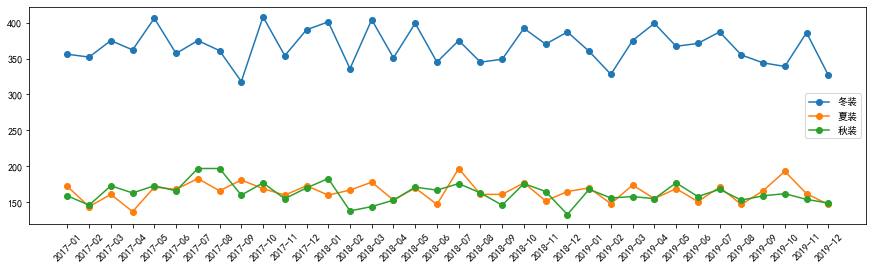

In [71]:
f,ax=plt.subplots(figsize=(15,4))
for col in product_month.columns:
    plt.plot(product_month[col],marker='o',linestyle='-')
    plt.xticks(rotation=45)
plt.legend(labels=['冬装','夏装','秋装'])
plt.show()

In [79]:
order_data.to_excel('./新订单表.xlsx')

In [77]:
product_month.reset_index()

产品类型,month,冬装,夏装,秋装
0,2017-01,356,172,159
1,2017-02,352,144,146
2,2017-03,375,161,173
3,2017-04,362,137,163
4,2017-05,406,171,173
5,2017-06,357,168,166
6,2017-07,375,183,197
7,2017-08,361,166,197
8,2017-09,318,181,160
9,2017-10,408,169,177


In [33]:
pd.pivot_table(order_data,columns=['产品类型','产品名称'],index='quater',values='订单ID',aggfunc='count')

产品类型     冬装                                           夏装                  秋装  \
产品名称   保暖内衣  冲锋衣   围巾   帽子   手套   棉衣   棉袜   毛衣  羽绒服   短袖   短裙   短裤   长裙   外套   
quater                                                                         
2017Q1  109  117  114  132  123  127  119  103  139  121  122  113  121  121   
2017Q2  112  117  142  131  144  123  126  115  115  113  118  124  121  119   
2017Q3  130  106  109   98  135  125  107  117  127  125  154  131  120  132   
2017Q4  132  135  141  108  106  112  123  155  140  114  127  134  127  127   
2018Q1  130  131  135  124  135  113  121  127  125  140  142  124   99  134   
2018Q2  110  124  125  111  137  124  115  117  132  129  125  118   98  117   
2018Q3  112  126  113  130  114  122  112  104  136  119  133  153  114  118   
2018Q4  128  147  123  117  125  128  116  141  124  151  113  117  113  111   
2019Q1  138  122  118  111  114  111  109  135  105  117  121  134  120  122   
2019Q2  122  120  139  135  130  117  137  110  127  118  112  133  112  126   
2019Q3  112  123  116  115  125  122  108  124  141  129  121  110  124  129   
2019Q4  133  114  125  112  114  121  103   98  132  123  123  130  126  113   

产品类型                   
产品名称     秋衣   秋裤   裤子  
quater                 
2017Q1  125  135   97  
2017Q2  148  108  127  
2017Q3  144  134  144  
2017Q4  132  125  118  
2018Q1  114  114  103  
2018Q2  124  119  131  
2018Q3  116  109  142  
2018Q4  126  114  123  
2019Q1  106  135  119  
2019Q2  130  107  127  
2019Q3  130  111  110  
2019Q4  116  114  122

# 重来

In [146]:
#计算每年GMV
order_year_df=order_data.groupby('year').agg({
    '销售额':'sum'
})

In [147]:
#每年交易用户数
order_year_df['交易用户数']=order_data[['year','客户ID']].drop_duplicates().groupby('year')['客户ID'].count()

In [150]:
order_year_df=order_year_df.rename(columns={'销售额':'GMV'})

In [152]:
order_data.head()

,产品ID,订单ID,客户ID,订单日期,发货日期,销售经理ID,利润,折扣,数量,是否退回,...,销售额,实际发货天数,产品类型,产品名称,产品单价,产品成本价,month,quater,year,1-12month
0,p1047,1,10221,2017-01-01 00:00:00,2017-01-02 00:00:00,sale003,10.90,1.0,1,0,...,29.9,1,冬装,围巾,29.9,19,2017-01,2017Q1,2017,1
1,p1614,2,10706,2017-01-01 00:00:00,2017-01-10 00:00:00,sale007,249.50,1.0,5,0,...,499.5,9,冬装,保暖内衣,99.9,50,2017-01,2017Q1,2017,1
2,p1614,3,10420,2017-01-01 00:00:00,2017-01-11 00:00:00,sale001,29.92,0.8,1,0,...,99.9,10,冬装,保暖内衣,99.9,50,2017-01,2017Q1,2017,1
3,p1898,4,10372,2017-01-01 00:00:00,2017-01-04 00:00:00,sale003,12.24,0.8,2,0,...,57.8,3,冬装,帽子,28.9,17,2017-01,2017Q1,2017,1
4,p1898,5,10250,2017-01-01 00:00:00,2017-01-07 00:00:00,sale003,0.34,0.6,1,0,...,28.9,6,冬装,帽子,28.9,17,2017-01,2017Q1,2017,1


In [154]:
order_year_df['订单数']=order_data.groupby('year')['订单ID'].count()

In [156]:
order_year_df['ARPU']=order_year_df['GMV']/order_year_df['交易用户数']

In [158]:
order_year_df['人均订单数']=order_year_df['订单数']/order_year_df['交易用户数']

In [159]:
order_year_df['单均价']=order_year_df['ARPU']/order_year_df['人均订单数']

In [176]:
order_year_df['商品量']=order_data.groupby('year')['数量'].sum()

In [180]:
order_year_df['单均商品量']=order_year_df['商品量']/order_year_df['交易用户数']/order_year_df['人均订单数']
#相当于order_data.groupby('year')['数量'].mean()

In [233]:
order_year_df

,GMV,交易用户数,订单数,ARPU,人均订单数,单均价,商品量,单均商品量
year,,,,,,,,
2017,5973039.2,790,8435,7560.809114,10.677215,708.125572,46438,5.505394
2018,6023146.9,790,8357,7624.236582,10.578481,720.730753,46291,5.539189
2019,5890699.0,790,8208,7456.581013,10.389873,717.677753,45230,5.510478


In [196]:
order_data[['产品单价','产品成本价','数量','折扣','利润','销售额']]
#（产品单价*折扣-产品成本价）*数量=利润
# 产品单价*数量=销售额
# GMV是去掉商品折扣后的金额

,产品单价,产品成本价,数量,折扣,利润,销售额
0,29.9,19,1,1.00,10.90,29.9
1,99.9,50,5,1.00,249.50,499.5
2,99.9,50,1,0.80,29.92,99.9
3,28.9,17,2,0.80,12.24,57.8
4,28.9,17,1,0.60,0.34,28.9
...,...,...,...,...,...,...
24995,199.9,90,1,1.00,109.90,199.9
24996,19.9,7,5,1.00,64.50,99.5
24997,19.9,7,7,1.00,90.30,139.3
24998,19.9,7,10,0.85,99.15,199.0


In [188]:
# order_data['现价']=order_data['产品单价']*order_data['折扣']
# order_year_df['商品均价']
order_year_df['原价']=order_data.groupby('year')['产品单价'].mean()
# order_year_df['折扣']=order_data.groupby('year')['折扣'].mean()

year
2017    129.339834
2018    129.984839
2019    130.176438
Name: 产品单价, dtype: float64

In [195]:
order_data.columns

Index(['产品ID', '订单ID', '客户ID', '订单日期', '发货日期', '销售经理ID', '利润', '折扣', '数量',
       '是否退回', '计划发货天数', '销售额', '实际发货天数', '产品类型', '产品名称', '产品单价', '产品成本价',
       'month', 'quater', 'year', '1-12month'],
      dtype='object')

In [194]:
order_data.groupby('year')['产品单价'].mean()

year
2017    129.339834
2018    129.984839
2019    130.176438
Name: 产品单价, dtype: float64

# 重来2

## 拆解GMV
- GMV是去掉商品折扣后的金额

In [6]:
#定义实际销售额
order_data['实际销售额']=order_data['产品单价']*order_data['折扣']*order_data['数量']

In [7]:
#所有订单
# unnormal_order=order_data[order_data['是否退回']==1]
order_df=order_data.groupby('year')['实际销售额'].sum().to_frame()
order_df=order_df.rename(columns={'实际销售额':'GMV'})
order_df['交易用户数']=order_data[['year','客户ID']].drop_duplicates().groupby('year')['客户ID'].count()
order_df['订单数']=order_data.groupby('year')['订单ID'].count()
order_df['人均订单数']=order_df['订单数']/order_df['交易用户数']
order_df['ARPU']=order_df['GMV']/order_df['交易用户数']
order_df['单均价']=order_df['ARPU']/order_df['人均订单数']
order_df['单均商品量']=order_data.groupby('year')['数量'].mean()
order_df['单原价']=order_data.groupby('year')['销售额'].mean()
order_df['单均折扣']=order_data.groupby('year')['折扣'].mean()
order_df['商品均价']=order_df['单原价']/order_df['单均商品量']


In [8]:
(order_df.diff().dropna().reset_index()/order_df.iloc[:2,:].reset_index()).drop(columns='year',axis=1).rename(index={
    0:'2017-2018',
    1:'2018-2019'
})

,GMV,交易用户数,订单数,人均订单数,ARPU,单均价,单均商品量,单原价,单均折扣,商品均价
2017-2018,0.008407,0.0,-0.009247,-0.009247,0.008407,0.017819,0.006138,0.017801,0.000439,0.011591
2018-2019,-0.022250,0.0,-0.017829,-0.017829,-0.022250,-0.004501,-0.005183,-0.004236,-0.001683,0.000952


In [9]:
order_df

,GMV,交易用户数,订单数,人均订单数,ARPU,单均价,单均商品量,单原价,单均折扣,商品均价
year,,,,,,,,,,
2017,5703011.795,790,8435,10.677215,7219.002272,676.112839,5.505394,708.125572,0.953136,128.623955
2018,5750958.850,790,8357,10.578481,7279.694747,688.160686,5.539189,720.730753,0.953554,130.114858
2019,5622999.330,790,8208,10.389873,7117.720671,685.063271,5.510478,717.677753,0.951949,130.238757


- 可以看出，18年GMV成交额有所提高后，在19年又快速下降，订单数，人均订单数都是接连下降，商品价格在18年上升后又下降
- 18年GMV上升是由于单均价上升，且单均价提高的原因是由于单原价提高，并且但均商品量提高，即定价提高，
- 19年GMV下降可能是订单量，单均价，折扣共同影响导致
- 交易用户数没有变化


In [10]:
order_data.columns

Index(['产品ID', '订单ID', '客户ID', '订单日期', '发货日期', '销售经理ID', '利润', '折扣', '数量',
       '是否退回', '计划发货天数', '销售额', '实际发货天数', '产品类型', '产品名称', '产品单价', '产品成本价',
       'month', 'quater', 'year', '1-12month', '实际销售额'],
      dtype='object')

In [11]:
#正常订单
normal_order=order_data[order_data['是否退回']!=1]


In [12]:
normal_order_df=normal_order.groupby('year')['实际销售额'].sum().to_frame()

In [13]:
normal_order_df=normal_order_df.rename(columns={'实际销售额':'GMV'})

In [14]:
normal_order_df['交易用户数']=normal_order[['year','客户ID']].drop_duplicates().groupby('year')['客户ID'].count()

In [15]:
normal_order_df['订单数']=normal_order.groupby('year')['订单ID'].count()

In [16]:
normal_order_df['人均订单数']=normal_order_df['订单数']/normal_order_df['交易用户数']
normal_order_df['ARPU']=normal_order_df['GMV']/normal_order_df['交易用户数']
normal_order_df['单均价']=normal_order_df['ARPU']/normal_order_df['人均订单数']

In [17]:
normal_order_df['单均商品量']=normal_order.groupby('year')['数量'].mean()
normal_order_df['单原价']=normal_order.groupby('year')['销售额'].mean()
normal_order_df['单均折扣']=normal_order.groupby('year')['折扣'].mean()
normal_order_df['商品均价']=normal_order_df['单原价']/normal_order_df['单均商品量']

In [18]:
(normal_order_df.diff().dropna().reset_index()/normal_order_df.iloc[:2,:].reset_index()).drop(columns='year',axis=1).rename(index={
    0:'2017-2018',
    1:'2018-2019'
})

,GMV,交易用户数,订单数,人均订单数,ARPU,单均价,单均商品量,单原价,单均折扣,商品均价
2017-2018,-0.006021,0.0,-0.013076,-0.013076,-0.006021,0.007148,0.004931,0.008034,-0.000261,0.003088
2018-2019,-0.005323,0.0,-0.010473,-0.010473,-0.005323,0.005205,-0.002759,0.005321,-0.001005,0.008102


In [19]:
normal_order_df

,GMV,交易用户数,订单数,人均订单数,ARPU,单均价,单均商品量,单原价,单均折扣,商品均价
year,,,,,,,,,,
2017,5461809.105,790,8030,10.164557,6913.682411,680.175480,5.506351,712.135915,0.953163,129.329912
2018,5428922.605,790,7925,10.031646,6872.053930,685.037553,5.533502,717.857375,0.952915,129.729316
2019,5400024.050,790,7842,9.926582,6835.473481,688.602914,5.518235,721.677200,0.951957,130.780436


- 可以看出2018,2019两年内正常订单的交易额持续下降，可以看出商品均价提高与单原价直接相关，而单原价提高是否影响订单数下降需要具体讨论
- 可以发现GMV下降的主要原因是人均订单数减少

In [20]:
#退货订单
unnormal_order=order_data[order_data['是否退回']==1]
unnormal_order_df=unnormal_order.groupby('year')['实际销售额'].sum().to_frame()
unnormal_order_df=unnormal_order_df.rename(columns={'实际销售额':'GMV'})
unnormal_order_df['交易用户数']=unnormal_order[['year','客户ID']].drop_duplicates().groupby('year')['客户ID'].count()
unnormal_order_df['订单数']=unnormal_order.groupby('year')['订单ID'].count()
unnormal_order_df['人均订单数']=unnormal_order_df['订单数']/unnormal_order_df['交易用户数']
unnormal_order_df['ARPU']=unnormal_order_df['GMV']/unnormal_order_df['交易用户数']
unnormal_order_df['单均价']=unnormal_order_df['ARPU']/unnormal_order_df['人均订单数']
unnormal_order_df['单均商品量']=unnormal_order.groupby('year')['数量'].mean()
unnormal_order_df['单原价']=unnormal_order.groupby('year')['销售额'].mean()
unnormal_order_df['单均折扣']=unnormal_order.groupby('year')['折扣'].mean()
unnormal_order_df['商品均价']=unnormal_order_df['单原价']/unnormal_order_df['单均商品量']


In [21]:
(unnormal_order_df.diff().dropna().reset_index()/unnormal_order_df.iloc[:2,:].reset_index()).drop(columns='year',axis=1).rename(index={
    0:'2017-2018',
    1:'2018-2019'
})

,GMV,交易用户数,订单数,人均订单数,ARPU,单均价,单均商品量,单原价,单均折扣,商品均价
2017-2018,0.335127,0.056250,0.066667,0.009862,0.264026,0.251682,0.028634,0.230398,0.013316,0.196147
2018-2019,-0.307608,-0.130178,-0.152778,-0.025983,-0.203985,-0.182751,-0.053027,-0.182894,-0.013987,-0.137139


In [22]:
unnormal_order_df

,GMV,交易用户数,订单数,人均订单数,ARPU,单均价,单均商品量,单原价,单均折扣,商品均价
year,,,,,,,,,,
2017,241202.690,320,405,1.265625,753.758406,595.562198,5.486420,628.611852,0.952593,114.575968
2018,322036.245,338,432,1.278107,952.769956,745.454271,5.643519,773.442593,0.965278,137.049713
2019,222975.280,294,366,1.244898,758.419320,609.222077,5.344262,631.984699,0.951776,118.254806


## 拆解利润
-（产品单价*折扣*是否退回- 成本)数量=利润
- 假设退货商品直接为负利润

In [23]:
order_data.columns

Index(['产品ID', '订单ID', '客户ID', '订单日期', '发货日期', '销售经理ID', '利润', '折扣', '数量',
       '是否退回', '计划发货天数', '销售额', '实际发货天数', '产品类型', '产品名称', '产品单价', '产品成本价',
       'month', 'quater', 'year', '1-12month', '实际销售额'],
      dtype='object')

In [24]:
order_data['实际利润']=order_data['实际销售额']*(1-order_data['是否退回'])-order_data['产品成本价']*order_data['数量']

In [25]:
order_data['折扣价']=order_data['产品单价']*order_data['折扣']
order_data['折扣后销售额']=order_data['折扣价']*order_data['数量']
order_data['成本总和']=order_data['产品成本价']*order_data['数量']

In [26]:
profit_order=order_data.groupby('year').agg({
    '实际利润':'sum',
    '是否退回':'sum',
    '数量':'sum',
    '销售额':'sum',
    '折扣后销售额':'sum',
    '成本总和':'sum'
})
profit_order['商品均利润']=profit_order['实际利润']/profit_order['数量']
profit_order['商品均原价']=profit_order['销售额']/profit_order['数量']

profit_order['商品均折扣价']=profit_order['折扣后销售额']/profit_order['数量']
profit_order['商品均成本']=profit_order['成本总和']/profit_order['数量']
profit_order['商品均折扣']=profit_order['商品均折扣价']/profit_order['商品均原价']

In [27]:
profit_order
#是否退回：1表示退回

,实际利润,是否退回,数量,销售额,折扣后销售额,成本总和,商品均利润,商品均原价,商品均折扣价,商品均成本,商品均折扣
year,,,,,,,,,,,
2017,2983218.105,405,46438,5973039.2,5703011.795,2478591,64.240883,128.623955,122.809160,53.374198,0.954792
2018,2945552.605,432,46291,6023146.9,5750958.850,2483370,63.631216,130.114858,124.234924,53.646929,0.954810
2019,2957382.050,366,45230,5890699.0,5622999.330,2442642,65.385409,130.238757,124.320127,54.004908,0.954556


In [28]:
(profit_order.diff().dropna().reset_index()/profit_order.iloc[:2,:].reset_index()).drop(columns='year',axis=1).rename(index={
    0:'2017-2018',
    1:'2018-2019'
})

,实际利润,是否退回,数量,销售额,折扣后销售额,成本总和,商品均利润,商品均原价,商品均折扣价,商品均成本,商品均折扣
2017-2018,-0.012626,0.066667,-0.003166,0.008389,0.008407,0.001928,-0.009490,0.011591,0.011610,0.005110,0.000018
2018-2019,0.004016,-0.152778,-0.022920,-0.021990,-0.022250,-0.016400,0.027568,0.000952,0.000686,0.006673,-0.000266



- 可以看出18年利润下降与商品退货有强相关，小部分与商品的成本提高有关
- 19年利润稍微回升，主要与退货比例下降有关，或者和商品打折有关

In [29]:
order_data['利润'].describe()

count    25000.000000
mean       386.894679
std        654.292739
min        -20.600000
25%         54.500000
50%        125.100000
75%        359.100000
max       3999.000000
Name: 利润, dtype: float64

In [30]:
order_data.columns

Index(['产品ID', '订单ID', '客户ID', '订单日期', '发货日期', '销售经理ID', '利润', '折扣', '数量',
       '是否退回', '计划发货天数', '销售额', '实际发货天数', '产品类型', '产品名称', '产品单价', '产品成本价',
       'month', 'quater', 'year', '1-12month', '实际销售额', '实际利润', '折扣价',
       '折扣后销售额', '成本总和'],
      dtype='object')

## 营收情况-时间维度


- 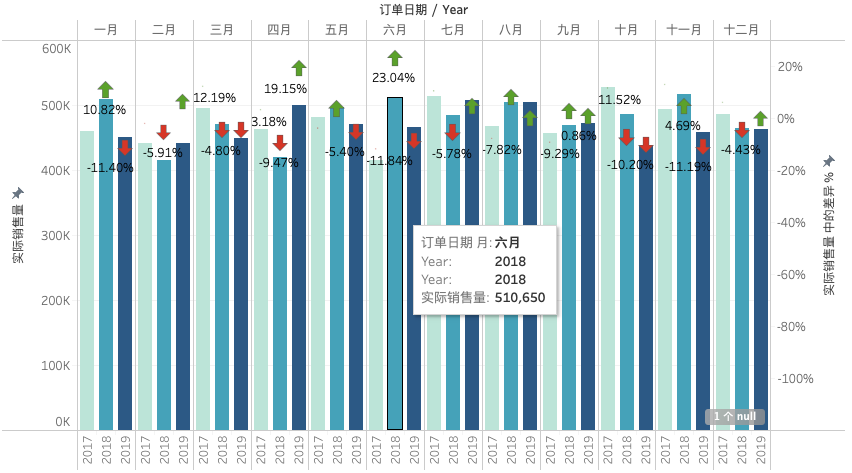

- 销售情况不存在周期性，三月，十月GMV同比增长率已连续下降，八月，九月GMV连续上升


In [31]:
city_data

,国家,地区,发货城市,城市ID
0,中国,东北,阿城,city001
1,中国,西北,阿克苏,city002
2,中国,华北,阿里河,city003
3,中国,中南,安埠,city004
4,中国,东北,安达,city005
...,...,...,...,...
587,中国,华东,诸暨,city588
588,中国,中南,驻马店,city589
589,中国,东北,庄河,city590
590,中国,西南,自贡,city591


In [32]:
order_district=order_data[['订单ID','是否退回','客户ID','实际销售额','实际利润','订单日期','year']].merge(cus_data[['客户ID','省/自治区','城市ID']]).merge(city_data[['城市ID','地区']])

In [315]:
order_district.to_excel('订单地区表.xlsx')

## 营收情况- 地区维度

- 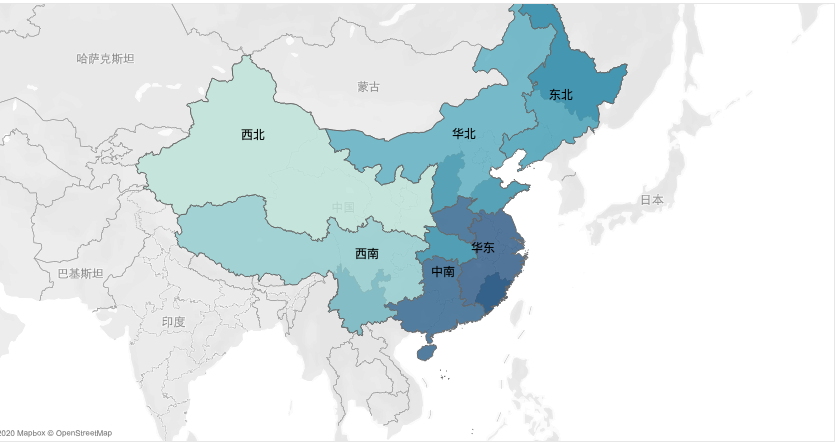

- 可以看出销售呈现明显地区分布，由西向东，由北到南销售额逐渐降低
- 东部大区（华东，中南，东北，华东）贡献87.44%的销售额，87.37%的利润
- 东南地区（华东，中南）销售额和利润均超50%

- 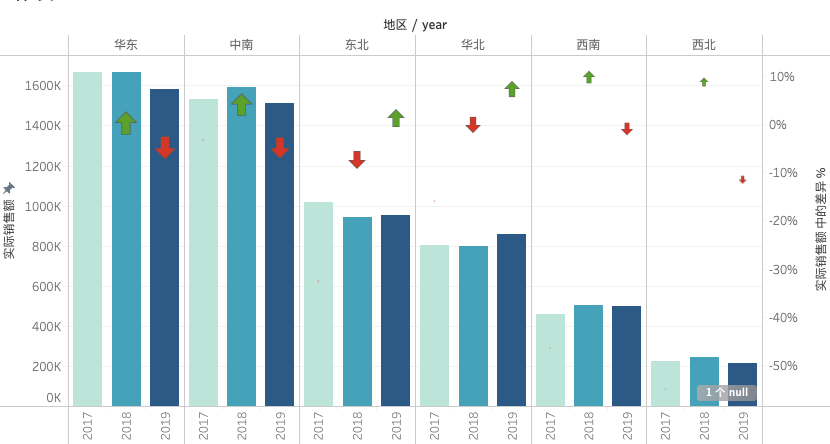

- 可以看出18年GMV存在北降男升的趋势，（东北华北地区GMV下降，华东，中南，西南，西北地区GMV上升）
- 19年的变化情况与18年相反，其中两年西北地区的GMV变化幅度最大
- 可能与各地区不同的营销方式有关

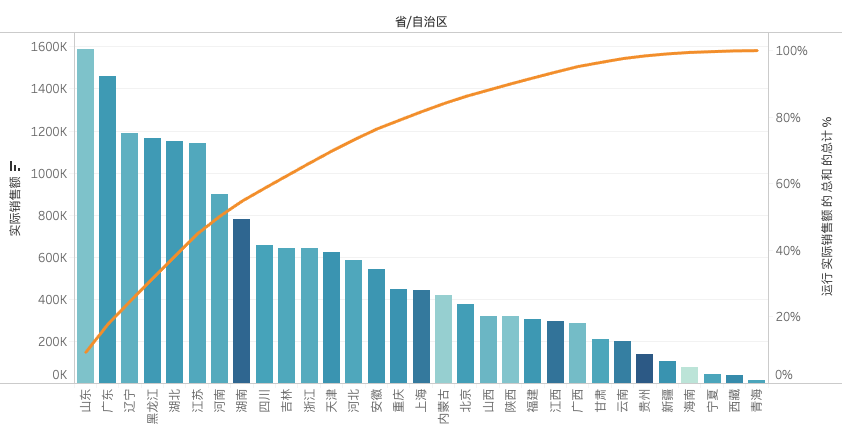

- 可以看出山东，广东，辽宁，黑龙江连续3年进入GMV前五
- 青海，宁夏，西藏，海南连续3年位于后五
- 贵州，湖南，江西，上海利润占GMV较高，营收情况较为健康

## 营收情况-品类维度

- 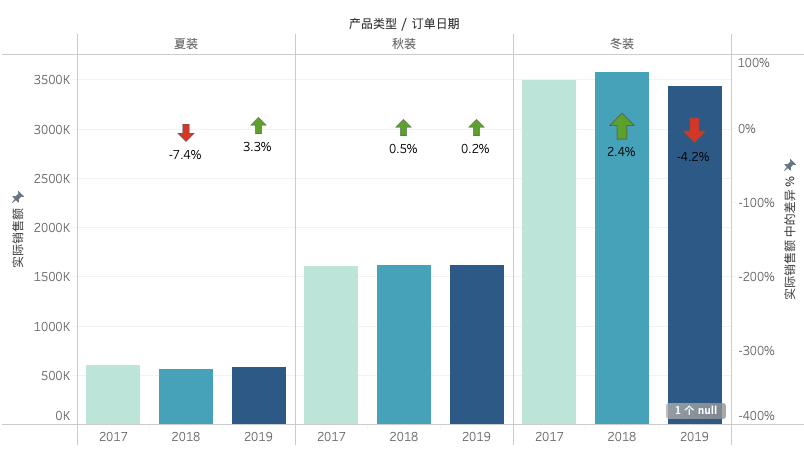

- 可以看出2017-2018年，各品类GMV出现不同变化，夏装下降7.4%，秋装和冬装分别上涨0.5%和2.4%
- 2018-2019年，冬装下降4.2%，夏装和秋装分别上涨3.3%和0.2%

In [320]:
year_cate=pd.pivot_table(order_data,index='year',columns='产品类型',values='订单ID',aggfunc='count')

In [322]:
year_cate

产品类型,冬装,夏装,秋装
year,,,
2017,4414,1985,2036
2018,4454,1988,1915
2019,4338,1953,1917


In [336]:
(year_cate.diff().dropna().reset_index()/year_cate.iloc[:2,:].reset_index()).drop(columns='year',axis=1).rename(index={
    0:'2017-2018',
    1:'2018-2019'
})

产品类型,冬装,夏装,秋装
2017-2018,0.009062,0.001511,-0.059430
2018-2019,-0.026044,-0.017606,0.001044


In [337]:
order_data.columns

Index(['产品ID', '订单ID', '客户ID', '订单日期', '发货日期', '销售经理ID', '利润', '折扣', '数量',
       '是否退回', '计划发货天数', '销售额', '实际发货天数', '产品类型', '产品名称', '产品单价', '产品成本价',
       'month', 'quater', 'year', '1-12month', '实际销售额', '折扣价', '折扣后销售额',
       '成本总和', '实际利润'],
      dtype='object')

In [47]:
new_order_df=order_data.groupby(['产品类型','year'])['实际销售额'].sum().to_frame()
new_order_df=new_order_df.rename(columns={'实际销售额':'GMV'})
new_order_df['交易用户数']=order_data[['产品类型','year','客户ID']].drop_duplicates().groupby(['产品类型','year'])['客户ID'].count()
new_order_df['订单数']=order_data.groupby(['产品类型','year'])['订单ID'].count()
new_order_df['人均订单数']=new_order_df['订单数']/new_order_df['交易用户数']
new_order_df['ARPU']=new_order_df['GMV']/new_order_df['交易用户数']
new_order_df['单均价']=new_order_df['ARPU']/new_order_df['人均订单数']
# new_order_df
new_order_df['单均商品量']=order_data.groupby(['产品类型','year'])['数量'].mean()
new_order_df['单原价']=order_data.groupby(['产品类型','year'])['销售额'].mean()
new_order_df['单均折扣']=order_data.groupby(['产品类型','year'])['折扣'].mean()
new_order_df['商品均价']=new_order_df['单原价']/order_df['单均商品量']

new_order_df

GMV  交易用户数   订单数     人均订单数         ARPU         单均价  \
产品类型 year                                                                
冬装   2017  3493345.165    787  4414  5.608640  4438.812154  791.423916   
     2018  3578028.680    789  4454  5.645120  4534.890596  803.329295   
     2019  3428498.390    787  4338  5.512071  4356.414727  790.340800   
夏装   2017   603455.165    735  1985  2.700680   821.027435  304.007640   
     2018   558647.765    712  1988  2.792135   784.617647  281.009942   
     2019   576898.975    725  1953  2.693793   795.722724  295.391180   
秋装   2017  1606211.465    736  2036  2.766304  2182.352534  788.905435   
     2018  1614282.405    723  1915  2.648686  2232.755747  842.967313   
     2019  1617601.965    720  1917  2.662500  2246.669396  843.819491   

              单均商品量         单原价      单均折扣        商品均价  
产品类型 year                                              
冬装   2017  5.497055  829.190440  0.952696  150.614181  
     2018  5.542658  841.532398  0.952728  151.923403  
     2019  5.494698  827.279023  0.952605  150.128371  
夏装   2017  5.604534  318.809824  0.953300   57.908628  
     2018  5.447183  293.620272  0.955936   53.007812  
     2019  5.498720  310.433231  0.949309   56.335086  
秋装   2017  5.426817  825.223527  0.953929  149.893631  
     2018  5.626632  883.156397  0.953003  159.437861  
     2019  5.558164  884.552165  0.953156  160.521870

In [49]:
new_order_df.columns

Index(['GMV', '交易用户数', '订单数', '人均订单数', 'ARPU', '单均价', '单均商品量', '单原价', '单均折扣',
       '商品均价'],
      dtype='object')

In [52]:
for i in new_order_df.columns:
    year_cate=pd.pivot_table(new_order_df,index='year',columns='产品类型',values=i)
    df=(year_cate.diff().dropna().reset_index()/year_cate.iloc[:2,:].reset_index()).drop(columns='year',axis=1).rename(index={
        0:'2017-2018',
        1:'2018-2019'
    })
    print('变量为',i)
    print(df)
    print('\n')

变量为 GMV
产品类型             冬装        夏装        秋装
2017-2018  0.024241 -0.074251  0.005025
2018-2019 -0.041791  0.032670  0.002056


变量为 交易用户数
产品类型             冬装        夏装        秋装
2017-2018  0.002541 -0.031293 -0.017663
2018-2019 -0.002535  0.018258 -0.004149


变量为 订单数
产品类型             冬装        夏装        秋装
2017-2018  0.009062  0.001511 -0.059430
2018-2019 -0.026044 -0.017606  0.001044


变量为 人均订单数
产品类型             冬装        夏装        秋装
2017-2018  0.006504  0.033864 -0.042518
2018-2019 -0.023569 -0.035221  0.005215


变量为 ARPU
产品类型             冬装        夏装        秋装
2017-2018  0.021645 -0.044347  0.023096
2018-2019 -0.039356  0.014153  0.006232


变量为 单均价
产品类型             冬装        夏装        秋装
2017-2018  0.015043 -0.075648  0.068528
2018-2019 -0.016168  0.051177  0.001011


变量为 单均商品量
产品类型             冬装        夏装        秋装
2017-2018  0.008296 -0.028076  0.036820
2018-2019 -0.008653  0.009461 -0.012169


变量为 单原价
产品类型             冬装        夏装        秋装
2017-2018  0.014884 -0.079011  0.07

- 可以看出18年GMV提升主要由于冬装产品导致，夏装下降7.43%,秋装上升0.50%,冬装上升2.42%
    - 冬装GMV上升的原因是单均价提高的原因1.50%，平均单件商品定价提高1.3元
    - 夏装GMV下降的原因是交易用户数（3.13%），折扣（8.46%），单均价（7.56%）共同所致，平均单件商品下降4.9元
- 19年GMV下降主要是冬装产品导致，冬装下降4.18%，夏装上升3.27%，秋装上升0.21%
    - 冬装GMV下降的原因是人均订单数（2.36%）和单均价（1.62%）共同导致，平均单件商品定价减少1.8元
    - 夏装GMV上升的原因是交易用户数（1.83%）和单均价（5.12%）共同导致，平均单件商品定价提高3.3元

# 客户交易情况
## 1.客户结构

In [57]:
order_data.columns

Index(['产品ID', '订单ID', '客户ID', '订单日期', '发货日期', '销售经理ID', '利润', '折扣', '数量',
       '是否退回', '计划发货天数', '销售额', '实际发货天数', '产品类型', '产品名称', '产品单价', '产品成本价',
       'month', 'quater', 'year', '1-12month', '实际销售额', '实际利润', '折扣价',
       '折扣后销售额', '成本总和'],
      dtype='object')

In [86]:
order_data['真实订单']=1-order_data['是否退回']

In [88]:
order_client=order_data.merge(cus_data,on='客户ID')

In [81]:
s1=pd.pivot_table(order_client,index='细分',columns='year',values='实际销售额',aggfunc='sum').mean(axis=1)

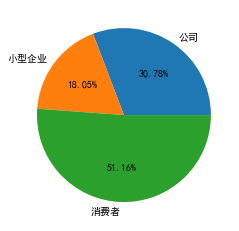

In [82]:
plt.pie(s1/s1.sum(),labels=s1.index,autopct='%1.2f%%')
plt.show()

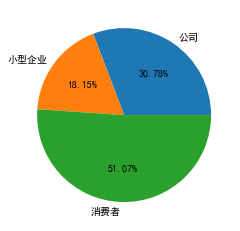

In [83]:
s1=pd.pivot_table(order_client,index='细分',columns='year',values='实际利润',aggfunc='sum').mean(axis=1)
plt.pie(s1/s1.sum(),labels=s1.index,autopct='%1.2f%%')
plt.show()

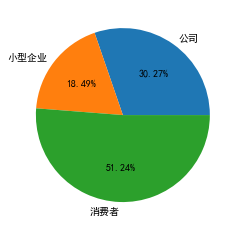

In [89]:
s1=pd.pivot_table(order_client,index='细分',columns='year',values='真实订单',aggfunc='sum').mean(axis=1)
plt.pie(s1/s1.sum(),labels=s1.index,autopct='%1.2f%%')
plt.show()

- 2017-2019年，消费者在年均实际销售额，年均实际利润，年均实际订单量都占据50%，是目前的消费主力

## 2.利用RFM和用户生命周期给用户打标签

In [93]:
order_data['实际销售额'].value_counts()
#实际销售额包含退货的，只是去掉折扣了

179.100    366
119.400    357
79.600     356
199.000    349
159.200    349
          ... 
67.830       2
719.880      2
479.840      2
239.200      1
284.905      1
Name: 实际销售额, Length: 805, dtype: int64

In [96]:
rfm=order_data.groupby('客户ID').agg({
    '订单日期':'max',
    '订单ID':'count',
    '实际销售额':'sum'
})

In [97]:
import datetime

In [99]:
dd='2020-11-23 12:29:00'
rfm['RR']=(pd.to_datetime(dd) - pd.to_datetime(rfm.订单日期)).dt.days
R_median=np.median(rfm.RR)
F_median=np.median(rfm.订单ID)
M_median=np.median(rfm.实际销售额)
rfm['R']=np.where(rfm.RR<R_median,'高','低')
rfm['F']=np.where(rfm.订单ID>F_median,'高','低')
rfm['M']=np.where(rfm.实际销售额>M_median,'高','低')
rfm['RFM']=rfm.R+rfm.F+rfm.M
RFM = {'高高高':'重要价值用户','高低高':'重要保持用户','低高高':'重要发展用户','低低高':'重要挽留用户','高高低':'一般价值用户','高低低':'一般发展用户','低高低':'一般保持用户','低低低':'一般挽留用户'}
rfm['RFMlevel'] = [RFM[i] for i in rfm.RFM.tolist()]


In [137]:
rfm.to_excel('用户价值.xlsx')

In [104]:
rfm=rfm.reset_index()
s1=rfm.groupby('RFMlevel')['客户ID'].count()/np.sum(rfm.groupby('RFMlevel')['客户ID'].count())

In [108]:
RFM.values()

dict_values(['重要价值用户', '重要保持用户', '重要发展用户', '重要挽留用户', '一般价值用户', '一般发展用户', '一般保持用户', '一般挽留用户'])

In [115]:
s1=s1.loc[RFM.values()]

In [133]:
s2=rfm.groupby('RFMlevel')['实际销售额'].sum()/np.sum(rfm.groupby('RFMlevel')['实际销售额'].sum())
s2=s2.loc[RFM.values()]

In [138]:
df=s1.reset_index().merge(s2.reset_index(),on='RFMlevel')

In [144]:
df.sort_values(by='客户ID',ascending=False)

,RFMlevel,客户ID,实际销售额
7,一般挽留用户,0.194937,0.143208
0,重要价值用户,0.179747,0.233542
2,重要发展用户,0.154430,0.195764
5,一般发展用户,0.150633,0.106752
4,一般价值用户,0.091139,0.074574
3,重要挽留用户,0.089873,0.104034
1,重要保持用户,0.075949,0.090881
6,一般保持用户,0.063291,0.051245


In [141]:
df.cumsum()

,RFMlevel,客户ID,实际销售额
0,重要价值用户,0.179747,0.233542
1,重要价值用户重要保持用户,0.255696,0.324423
2,重要价值用户重要保持用户重要发展用户,0.410127,0.520187
3,重要价值用户重要保持用户重要发展用户重要挽留用户,0.500000,0.624221
4,重要价值用户重要保持用户重要发展用户重要挽留用户一般价值用户,0.591139,0.698795
5,重要价值用户重要保持用户重要发展用户重要挽留用户一般价值用户一般发展用户,0.741772,0.805547
6,重要价值用户重要保持用户重要发展用户重要挽留用户一般价值用户一般发展用户一般保持用户,0.805063,0.856792
7,重要价值用户重要保持用户重要发展用户重要挽留用户一般价值用户一般发展用户一般保持用户一般挽留用户,1.000000,1.000000


- 基于2017-2019年的数据建立RFM模型进行客户分类，四类重要客户对销售额贡献超60%，人数占比为50%，客户营收结构和数量结构较为良好
- 一般挽留客户人数占比接近20%，客户流失存在可能，需引起重视

In [150]:
order_data.订单日期.min()

datetime.datetime(2017, 1, 1, 0, 0)

In [151]:
dd=['2017-07-01 00:00:00','2018-01-01 00:00:00','2018-07-01 00:00:00',
    '2019-01-01 00:00:00','2019-07-01 00:00:00','2020-01-01 00:00:00','2020-07-01 00:00:00','2020-11-23 00:00:00']

In [159]:
s1.reset_index().iloc[:,0].to_frame()

,RFMlevel
0,重要价值用户
1,重要保持用户
2,重要发展用户
3,重要挽留用户
4,一般价值用户
5,一般发展用户
6,一般保持用户
7,一般挽留用户


In [170]:
rfm_num=s1.reset_index().iloc[:,1].to_frame()
rfm_money=s1.reset_index().iloc[:,1].to_frame()
for d in dd:
    order_data1=order_data.copy()
    order_data1=order_data[(pd.to_datetime(d)-pd.to_datetime(order_data.订单日期)).dt.days>0]
    rfm=order_data1.groupby('客户ID').agg({
    '订单日期':'max',
    '订单ID':'count',
    '实际销售额':'sum'
    }).reset_index()
    rfm['RR']=(pd.to_datetime(d) - pd.to_datetime(rfm.订单日期)).dt.days
    R_median=np.median(rfm.RR)
    F_median=np.median(rfm.订单ID)
    M_median=np.median(rfm.实际销售额)
    rfm['R']=np.where(rfm.RR<R_median,'高','低')
    rfm['F']=np.where(rfm.订单ID>F_median,'高','低')
    rfm['M']=np.where(rfm.实际销售额>M_median,'高','低')
    rfm['RFM']=rfm.R+rfm.F+rfm.M
    RFM = {'高高高':'重要价值用户','高低高':'重要保持用户','低高高':'重要发展用户','低低高':'重要挽留用户','高高低':'一般价值用户','高低低':'一般发展用户','低高低':'一般保持用户','低低低':'一般挽留用户'}
    rfm['RFMlevel'] = [RFM[i] for i in rfm.RFM.tolist()]
    s1=rfm.groupby('RFMlevel')['客户ID'].count()/np.sum(rfm.groupby('RFMlevel')['客户ID'].count())
    s1=s1.loc[RFM.values()].reset_index()
    rfm_num=rfm_num.merge(s1,on='RFMlevel').rename(columns={'客户ID':d[:7]})
    s2=rfm.groupby('RFMlevel')['实际销售额'].sum()/np.sum(rfm.groupby('RFMlevel')['实际销售额'].sum())
    s2=s2.loc[RFM.values()].reset_index()
    rfm_money=rfm_num.merge(s2,on='RFMlevel').rename(columns={'实际销售额':d[:7]})
    
    

In [175]:
rfm_num

,RFMlevel,2017-07,2018-01,2018-07,2019-01,2019-07,2020-01,2020-07,2020-11
0,重要价值用户,0.196429,0.191139,0.177215,0.196203,0.189873,0.179747,0.179747,0.179747
1,重要保持用户,0.080357,0.069620,0.103797,0.078481,0.078481,0.075949,0.075949,0.075949
2,重要发展用户,0.116071,0.135443,0.124051,0.126582,0.134177,0.154430,0.154430,0.154430
3,重要挽留用户,0.107143,0.103797,0.094937,0.098734,0.097468,0.089873,0.089873,0.089873
4,一般价值用户,0.073980,0.089873,0.053165,0.058228,0.065823,0.091139,0.091139,0.091139
5,一般发展用户,0.135204,0.145570,0.160759,0.159494,0.159494,0.150633,0.150633,0.150633
6,一般保持用户,0.054847,0.077215,0.054430,0.069620,0.065823,0.063291,0.063291,0.063291
7,一般挽留用户,0.235969,0.187342,0.231646,0.212658,0.208861,0.194937,0.194937,0.194937


- 从时间维度看，重要价值客户，重要保持客户，一般发展用户，一般挽留用户在17-18年比例上升，18-19年数量比例减少
- 重要发展用户，一般价值用户在17-18年比例下降，在18-19年比例上升
- 重要挽留客户，一般保持用户比例逐渐下降

In [176]:
rfm_money

,RFMlevel,2017-07,2018-01,2018-07,2019-01,2019-07,2020-01,2020-07,2020-11,2020-11
0,重要价值用户,0.196429,0.191139,0.177215,0.196203,0.189873,0.179747,0.179747,0.179747,0.233542
1,重要保持用户,0.080357,0.069620,0.103797,0.078481,0.078481,0.075949,0.075949,0.075949,0.090881
2,重要发展用户,0.116071,0.135443,0.124051,0.126582,0.134177,0.154430,0.154430,0.154430,0.195764
3,重要挽留用户,0.107143,0.103797,0.094937,0.098734,0.097468,0.089873,0.089873,0.089873,0.104034
4,一般价值用户,0.073980,0.089873,0.053165,0.058228,0.065823,0.091139,0.091139,0.091139,0.074574
5,一般发展用户,0.135204,0.145570,0.160759,0.159494,0.159494,0.150633,0.150633,0.150633,0.106752
6,一般保持用户,0.054847,0.077215,0.054430,0.069620,0.065823,0.063291,0.063291,0.063291,0.051245
7,一般挽留用户,0.235969,0.187342,0.231646,0.212658,0.208861,0.194937,0.194937,0.194937,0.143208


## 3.查找羊毛党用户